In [1]:
import tensorflow as tf
import glob
import nibabel as nib
import os
import time

import pandas as pd
import numpy as np

from mricode.utils import log_textfile
from mricode.utils import copy_colab

tf.__version__

'2.0.0'

In [3]:
tf.test.is_gpu_available()

True

In [5]:
path_output = './'
path_tfrecords = '/data2/res64/down/'
path_csv = '/data2/csv/'
#path_csv = '/content/drive/My Drive/Capstone/05_Data/01_Label/'
filename_res = {'train': 'intell_residual_train.csv', 'val': 'intell_residual_valid.csv', 'test': 'intell_residual_test.csv'}
filename_norm = {'train': 'intell_train.csv', 'val': 'intell_valid.csv', 'test': 'intell_test.csv'}
filename_fluid = {'train': 'training_fluid_intelligence_sri.csv', 'val': 'validation_fluid_intelligence_sri.csv', 'test': 'test_fluid_intelligence_sri.csv'}
filename_final = filename_res
sample_size = 'site16_allimages'
batch_size = 8
onlyt1 = False
t1_mean = 0.35196779465675354 
t2_mean = 0.5694633522033692
t1_std = 0.8948413240464094
t2_std = 1.2991791534423829

In [8]:
def return_iter(path, sample_size, batch_size=8, onlyt1=False):
  # Some definitions
  if onlyt1:
    read_features = {
      't1': tf.io.FixedLenFeature([], dtype=tf.string),
      'subjectid': tf.io.FixedLenFeature([], dtype=tf.string)
    }
  else:
    read_features = {
      't1': tf.io.FixedLenFeature([], dtype=tf.string),
      't2': tf.io.FixedLenFeature([], dtype=tf.string),
      'subjectid': tf.io.FixedLenFeature([], dtype=tf.string)
    }
  def _parse_(serialized_example, decoder = np.vectorize(lambda x: x.decode('UTF-8')), onlyt1=False):
    example = tf.io.parse_single_example(serialized_example, read_features)
    subjectid = example['subjectid']
    if not(onlyt1):
      t1 = tf.expand_dims(tf.reshape(tf.io.decode_raw(example['t1'], tf.int8), (64,64,64)), axis=-1)
      t2 = tf.expand_dims(tf.reshape(tf.io.decode_raw(example['t2'], tf.float32), (64,64,64)), axis=-1)
      return ({'t1': t1, 't2': t2, 'subjectid': subjectid})
    else:
      t1 = tf.expand_dims(tf.reshape(tf.io.decode_raw(example['t1'], tf.int8), (256,256,256)), axis=-1)
      return ({'t1': t1, 'subjectid': subjectid})
  
  train_ds = tf.data.TFRecordDataset(path +'t1t2_train_' + str(sample_size) + '_v4.tfrecords')
  val_ds = tf.data.TFRecordDataset(path + 't1t2_val_' + str(sample_size) + '_v4.tfrecords')
  test_ds = tf.data.TFRecordDataset(path + 't1t2_test_' + str(sample_size) + '_v4.tfrecords')
  train_iter = train_ds.map(lambda x:_parse_(x, onlyt1=onlyt1)).shuffle(True).batch(batch_size)
  val_iter = val_ds.map(lambda x:_parse_(x, onlyt1=onlyt1)).batch(batch_size)
  test_iter = test_ds.map(lambda x:_parse_(x, onlyt1=onlyt1)).batch(batch_size)
  return train_iter, val_iter, test_iter

def return_csv(path, filenames={'train': 'intell_train.csv', 'val': 'intell_valid.csv', 'test': 'intell_test.csv'}, fluid = False):
  train_df = pd.read_csv(path + filenames['train'])
  val_df = pd.read_csv(path + filenames['val'])
  test_df = pd.read_csv(path + filenames['test'])
  norm = None
  if fluid:
    train_df.columns = ['subjectkey', 'fluid_res', 'fluid']
    val_df.columns = ['subjectkey', 'fluid_res', 'fluid']
    test_df.columns = ['subjectkey', 'fluid_res', 'fluid']
  train_df['subjectkey'] = train_df['subjectkey'].str.replace('_', '')
  val_df['subjectkey'] = val_df['subjectkey'].str.replace('_', '')
  test_df['subjectkey'] = test_df['subjectkey'].str.replace('_', '')
  if not(fluid):
    for df in [train_df, val_df, test_df]:
      df['race.ethnicity'] = df['race.ethnicity'] - 1
      df['married'] = df['married'] - 1
      df['high.educ_group'] = 0
      df.loc[(train_df['high.educ']>=11) & (df['high.educ']<=12),'high.educ_group'] = 1
      df.loc[(train_df['high.educ']>=13) & (df['high.educ']<=13),'high.educ_group'] = 2
      counter = 3
      for i in range(14,22):
        df.loc[(df['high.educ']>=i) & (df['high.educ']<=i),'high.educ_group'] = counter
      df['income_group'] = 0
      counter = 1
      for i in range(4,11):
        df.loc[(df['income']>=i) & (df['income']<=i),'income_group'] = counter
        counter += 1
    norm = {}
    for col in ['BMI', 'age', 'vol', 'weight', 'height', 'nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 
                'nihtbx_pattern_uncorrected', 'nihtbx_picture_uncorrected', 
                'nihtbx_list_uncorrected', 'nihtbx_flanker_uncorrected',
                'nihtbx_picvocab_uncorrected', 'nihtbx_cardsort_uncorrected',
                'nihtbx_totalcomp_uncorrected', 'nihtbx_reading_uncorrected']:
      mean = train_df[col].mean()
      std = train_df[col].std()
      train_df[col + '_norm'] = (train_df[col]-mean)/std
      val_df[col + '_norm'] = (val_df[col]-mean)/std
      test_df[col + '_norm'] = (test_df[col]-mean)/std
      norm[col] = {'mean': mean, 'std': std}
  return train_df, val_df, test_df, norm

In [9]:
train_iter, val_iter, test_iter = return_iter(path_tfrecords, sample_size, batch_size, onlyt1=onlyt1)

In [10]:
a = next(iter(train_iter))

In [11]:
if False:
  t1_mean = 0.
  t1_std = 0.
  t2_mean = 0.
  t2_std = 0.
  n = 0.
  for b in train_iter:
      t1_mean += np.mean(b['t1'])
      t1_std += np.std(b['t1'])
      t2_mean += np.mean(b['t2'])
      t2_std += np.std(b['t2'])
      n += np.asarray(b['t1']).shape[0]

  t1_mean /= n
  t1_std /= n
  t2_mean /= n
  t2_std /= n

In [12]:
t1_mean, t1_std, t2_mean, t2_std

(0.35196779465675354,
 0.8948413240464094,
 0.5694633522033692,
 1.2991791534423829)

In [13]:
train_df, val_df, test_df, norm_dict = return_csv(path_csv, filename_final, False)

In [14]:
norm_dict

{'BMI': {'mean': 18.681548127052135, 'std': 4.193043131845343},
 'age': {'mean': 119.00325844623563, 'std': 7.479129774017182},
 'height': {'mean': 55.25173666322929, 'std': 3.152756181679028},
 'nihtbx_cardsort_uncorrected': {'mean': 0.01902727147573316,
  'std': 0.92710655806542},
 'nihtbx_cryst_uncorrected': {'mean': 0.007018628014748754,
  'std': 0.7845373584638602},
 'nihtbx_flanker_uncorrected': {'mean': 0.02188780794049048,
  'std': 0.9070917080607726},
 'nihtbx_fluidcomp_uncorrected': {'mean': 0.020178243913565427,
  'std': 0.86606123778624},
 'nihtbx_list_uncorrected': {'mean': 0.00625176016120734,
  'std': 0.8898550695735616},
 'nihtbx_pattern_uncorrected': {'mean': 0.020721412569885096,
  'std': 0.9486618556882954},
 'nihtbx_picture_uncorrected': {'mean': 0.0005782175223803825,
  'std': 0.9577989703304521},
 'nihtbx_picvocab_uncorrected': {'mean': 0.0068509109986280275,
  'std': 0.8038465951211212},
 'nihtbx_reading_uncorrected': {'mean': 0.0027847502208883574,
  'std': 0.85

In [15]:
train_df.max()

subjectkey                           NDARINVZZZNB0XC
age                                              131
female                                             1
race.ethnicity                                     4
high.educ                                         21
income                                            10
married                                            5
abcd_site                                         22
vol                                          3.96307
height                                            81
weight                                           272
BMI                                          54.9929
nihtbx_fluidcomp_uncorrected                 3.14844
nihtbx_cryst_uncorrected                     3.46236
nihtbx_pattern_uncorrected                   3.20819
nihtbx_picture_uncorrected                   2.91261
nihtbx_list_uncorrected                      2.87982
nihtbx_flanker_uncorrected                   2.60289
nihtbx_picvocab_uncorrected                  3

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D
from tensorflow import nn
from tensorflow.python.ops import nn_ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.base_layer import InputSpec
from tensorflow.python.keras.utils import conv_utils

In [17]:
cat_cols = {'female': 2, 'race.ethnicity': 5, 'high.educ_group': 4, 'income_group': 8, 'married': 6}
#cat_cols = {}
num_cols = [x for x in list(val_df.columns) if '_norm' in x]
#num_cols = num_cols[0:3]

In [18]:
num_cols

['BMI_norm',
 'age_norm',
 'vol_norm',
 'weight_norm',
 'height_norm',
 'nihtbx_fluidcomp_uncorrected_norm',
 'nihtbx_cryst_uncorrected_norm',
 'nihtbx_pattern_uncorrected_norm',
 'nihtbx_picture_uncorrected_norm',
 'nihtbx_list_uncorrected_norm',
 'nihtbx_flanker_uncorrected_norm',
 'nihtbx_picvocab_uncorrected_norm',
 'nihtbx_cardsort_uncorrected_norm',
 'nihtbx_totalcomp_uncorrected_norm',
 'nihtbx_reading_uncorrected_norm']

In [19]:
from tensorflow.keras import Model

class MyDNN(Model):
  def __init__(self, cat_cols, num_cols):
    super(MyDNN, self).__init__()
    self.cat_cols = cat_cols
    self.num_cols = num_cols
    self.ac = tf.keras.layers.ReLU()
    self.maxpool = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv1 = tf.keras.layers.Conv3D(
        filters = 1,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv3D(
        filters = 16,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv3 = tf.keras.layers.Conv3D(
        filters = 32,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv3D(
        filters = 256,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.fc = {}
    for k in list(self.cat_cols.keys()):
      self.fc[k] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(self.cat_cols[k], activation='softmax')
                                        ])
    for i in range(len(self.num_cols)):
      self.fc[self.num_cols[i]] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(1)
                                        ])
    #self.fc1 = tf.keras.Sequential([
    #                                    tf.keras.layers.Dense(256, activation='relu'),
    #                                    tf.keras.layers.BatchNormalization(),
    #                                    tf.keras.layers.Dense(1)
    #                                    ])
    #self.fc2 = tf.keras.Sequential([
    #                                tf.keras.layers.Dense(256, activation='relu'),
    #                                tf.keras.layers.BatchNormalization(),
    #                                tf.keras.layers.Dense(1)
    #                                ])
    #self.fc3 = tf.keras.Sequential([
    #                                tf.keras.layers.Dense(256, activation='relu'),
    #                                tf.keras.layers.BatchNormalization(),
    #                                tf.keras.layers.Dense(1)
    #                                ])

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.ac(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    out = {}
    for k in list(self.fc.keys()):
      out[k] = self.fc[k](x)
    #['age_norm', 'vol_norm', 'weight_norm']
    #out['age_norm'] = self.fc1(x)
    #out['vol_norm'] = self.fc2(x)
    #out['weight_norm'] = self.fc3(x)
    return out

In [20]:
from tensorflow.keras import Model

class MyDNN(Model):
  def __init__(self, cat_cols, num_cols):
    super(MyDNN, self).__init__()
    self.cat_cols = cat_cols
    self.num_cols = num_cols
    self.ac = tf.keras.layers.ReLU()
    self.maxpool = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv1 = tf.keras.layers.Conv3D(
        filters = 32,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last',
        input_shape = (64,64,64,2)
    )
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv3D(
        filters = 64,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv3 = tf.keras.layers.Conv3D(
        filters = 128,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv3D(
        filters = 256,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.fc = {}
    for k in list(self.cat_cols.keys()):
      self.fc[k] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(self.cat_cols[k], activation='softmax')
                                        ])
    for i in range(len(self.num_cols)):
      self.fc[self.num_cols[i]] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(1)
                                        ])

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.ac(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    out = {}
    for k in list(self.fc.keys()):
      out[k] = self.fc[k](x)
    return out

In [21]:
from tensorflow.keras import Model

class MyDNN(Model):
  def __init__(self, cat_cols, num_cols):
    super(MyDNN, self).__init__()
    self.cat_cols = cat_cols
    self.num_cols = num_cols
    self.ac = tf.keras.layers.ReLU()
    self.maxpool = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv1 = tf.keras.layers.Conv3D(
        filters = 32,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last',
        input_shape = (64,64,64,2)
    )
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv3D(
        filters = 64,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv3 = tf.keras.layers.Conv3D(
        filters = 128,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv3D(
        filters = 256,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last',
        name='lastconv_1'
    )
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.fc = {}
    for k in list(self.cat_cols.keys()):
      self.fc[k] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(self.cat_cols[k], activation='softmax', name='output_' + k)
                                        ])
    for i in range(len(self.num_cols)):
      self.fc[self.num_cols[i]] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(1)
                                        ])

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.ac(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    out = {}
    for k in list(self.fc.keys()):
      out[k] = self.fc[k](x)
    return out

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [27]:
def calc_loss_acc(out_loss, out_acc, y_true, y_pred, cat_cols, num_cols, norm_dict):
  for col in num_cols:
    tmp_col = col
    tmp_std = norm_dict[tmp_col.replace('_norm','')]['std']
    tmp_y_true = tf.cast(y_true[col], tf.float32).numpy()
    tmp_y_pred = np.squeeze(y_pred[col].numpy())
    if not(tmp_col in out_loss):
      out_loss[tmp_col] = np.sum(np.square(tmp_y_true-tmp_y_pred))
    else:
      out_loss[tmp_col] += np.sum(np.square(tmp_y_true-tmp_y_pred))
    if not(tmp_col in out_acc):
      out_acc[tmp_col] = np.sum(np.square((tmp_y_true-tmp_y_pred)*tmp_std))
    else:
      out_acc[tmp_col] += np.sum(np.square((tmp_y_true-tmp_y_pred)*tmp_std))
  for col in list(cat_cols.keys()):
    tmp_col = col
    if not(tmp_col in out_loss):
      out_loss[tmp_col] = tf.keras.losses.SparseCategoricalCrossentropy()(tf.squeeze(y_true[col]), tf.squeeze(y_pred[col])).numpy()
    else:
      out_loss[tmp_col] += tf.keras.losses.SparseCategoricalCrossentropy()(tf.squeeze(y_true[col]), tf.squeeze(y_pred[col])).numpy()
    if not(tmp_col in out_acc):
      out_acc[tmp_col] = tf.reduce_sum(tf.dtypes.cast((y_true[col] == tf.argmax(y_pred[col], axis=-1)), tf.float32)).numpy()
    else:
      out_acc[tmp_col] += tf.reduce_sum(tf.dtypes.cast((y_true[col] == tf.argmax(y_pred[col], axis=-1)), tf.float32)).numpy()    
  return(out_loss, out_acc)

def format_output(out_loss, out_acc, n, cols, print_bl=False):
  loss = 0
  acc = 0
  output = []
  for col in cols:
    output.append([col, out_loss[col]/n, out_acc[col]/n])
    loss += out_loss[col]/n
    acc += out_acc[col]/n
  df = pd.DataFrame(output)
  df.columns = ['name', 'loss', 'acc']
  if print_bl:
    print(df)
  return(loss, acc, df)

@tf.function
def train_step(X, y, model, optimizer, cat_cols, num_cols):
  with tf.GradientTape() as tape:
    predictions = model(X)
    i = 0
    loss = tf.keras.losses.MSE(tf.cast(y[num_cols[i]], tf.float32), tf.squeeze(predictions[num_cols[i]]))
    for i in range(1,len(num_cols)):
      loss += tf.keras.losses.MSE(tf.cast(y[num_cols[i]], tf.float32), tf.squeeze(predictions[num_cols[i]]))
    for col in list(cat_cols.keys()):
      loss += tf.keras.losses.SparseCategoricalCrossentropy()(tf.squeeze(y[col]), tf.squeeze(predictions[col]))
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return(y, predictions, loss)

@tf.function
def test_step(X, y, model):
  predictions = model(X)
  return(y, predictions)

def epoch(data_iter, df, model, optimizer, cat_cols, num_cols, norm_dict):
  out_loss = {}
  out_acc = {}
  n = 0.
  n_batch = 0.
  total_time_dataload = 0.
  total_time_model = 0.
  start_time = time.time()
  for batch in data_iter:
    total_time_dataload += time.time() - start_time
    start_time = time.time()
    t1 = (tf.cast(batch['t1'], tf.float32)-t1_mean)/t1_std
    t2 = (batch['t2']-t2_mean)/t2_std
    subjectid = decoder(batch['subjectid'])
    y = get_labels(df, subjectid, list(cat_cols.keys())+num_cols)
    X = tf.concat([t1, t2], axis=4)
    if optimizer != None:
      y_true, y_pred, loss = train_step(X, y, model, optimizer, cat_cols, num_cols)
    else:
      y_true, y_pred = test_step(X, y, model)
    out_loss, out_acc = calc_loss_acc(out_loss, out_acc, y_true, y_pred, cat_cols, num_cols, norm_dict)
    n += X.shape[0]
    n_batch += 1
    if (n_batch % 10) == 0:
      print(n_batch)
    total_time_model += time.time() - start_time
    start_time = time.time()
  return (out_loss, out_acc, n, total_time_model, total_time_dataload)

def get_labels(df, subjectid, cols = ['nihtbx_fluidcomp_uncorrected_norm']):
  subjects_df = pd.DataFrame(subjectid)
  result_df = pd.merge(subjects_df, df, left_on=0, right_on='subjectkey', how='left')
  output = {}
  for col in cols:
    output[col] = np.asarray(result_df[col].values)
  return output

def best_val(df_best, df_val, df_test):
  df_best = pd.merge(df_best, df_val, how='left', left_on='name', right_on='name')
  df_best = pd.merge(df_best, df_test, how='left', left_on='name', right_on='name')
  df_best.loc[df_best['best_loss_val']>=df_best['cur_loss_val'], 'best_loss_test'] = df_best.loc[df_best['best_loss_val']>=df_best['cur_loss_val'], 'cur_loss_test']
  df_best.loc[df_best['best_loss_val']>=df_best['cur_loss_val'], 'best_loss_val'] = df_best.loc[df_best['best_loss_val']>=df_best['cur_loss_val'], 'cur_loss_val']
  df_best.loc[(df_best['best_acc_val']<=df_best['cur_acc_val'])&(df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'best_acc_test'] = df_best.loc[(df_best['best_acc_val']<=df_best['cur_acc_val'])&(df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'cur_acc_test']
  df_best.loc[(df_best['best_acc_val']<=df_best['cur_acc_val'])&(df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'best_acc_val'] = df_best.loc[(df_best['best_acc_val']<=df_best['cur_acc_val'])&(df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'cur_acc_val']
  df_best.loc[(df_best['best_acc_val']>=df_best['cur_acc_val'])&(~df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'best_acc_test'] = df_best.loc[(df_best['best_acc_val']>=df_best['cur_acc_val'])&(~df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'cur_acc_test']
  df_best.loc[(df_best['best_acc_val']>=df_best['cur_acc_val'])&(~df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'best_acc_val'] = df_best.loc[(df_best['best_acc_val']>=df_best['cur_acc_val'])&(~df_best['name'].isin(['female', 'race.ethnicity', 'high.educ_group', 'income_group', 'married'])), 'cur_acc_val']
  df_best = df_best.drop(['cur_loss_val', 'cur_acc_val', 'cur_loss_test', 'cur_acc_test'], axis=1)
  return(df_best)

In [28]:
cat_cols, num_cols

({'female': 2,
  'high.educ_group': 4,
  'income_group': 8,
  'married': 6,
  'race.ethnicity': 5},
 ['BMI_norm',
  'age_norm',
  'vol_norm',
  'weight_norm',
  'height_norm',
  'nihtbx_fluidcomp_uncorrected_norm',
  'nihtbx_cryst_uncorrected_norm',
  'nihtbx_pattern_uncorrected_norm',
  'nihtbx_picture_uncorrected_norm',
  'nihtbx_list_uncorrected_norm',
  'nihtbx_flanker_uncorrected_norm',
  'nihtbx_picvocab_uncorrected_norm',
  'nihtbx_cardsort_uncorrected_norm',
  'nihtbx_totalcomp_uncorrected_norm',
  'nihtbx_reading_uncorrected_norm'])

In [29]:
modelname = 'site16_downsample_t1t2_test_'

In [30]:
decoder = np.vectorize(lambda x: x.decode('UTF-8'))
template = 'Epoch {0}, Loss: {1:.3f}, Accuracy: {2:.3f}, Val Loss: {3:.3f}, Val Accuracy: {4:.3f}, Time Model: {5:.3f}, Time Data: {6:.3f}'
for col in [0]:
  log_textfile(path_output + modelname + 'multitask_test' + '.log', cat_cols),
  log_textfile(path_output + modelname + 'multitask_test' + '.log', num_cols)
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  optimizer = tf.keras.optimizers.Adam(lr = 0.001)
  model = MyDNN(cat_cols, num_cols)
  df_best = None
  for e in range(10):
    log_textfile(path_output + modelname + 'multitask_test' + '.log', 'Epochs: ' + str(e))
    loss = tf.Variable(0.)
    acc = tf.Variable(0.) 
    val_loss = tf.Variable(0.)
    val_acc = tf.Variable(0.)
    test_loss = tf.Variable(0.)
    test_acc = tf.Variable(0.)  
    train_out_loss, train_out_acc, n, time_model, time_data = epoch(train_iter, train_df, model, optimizer, cat_cols, num_cols, norm_dict)
    val_out_loss, val_out_acc, n, _, _ = epoch(val_iter, val_df, model, None, cat_cols, num_cols, norm_dict)
    test_out_loss, test_out_acc, n, _, _ = epoch(test_iter, test_df, model, None, cat_cols, num_cols, norm_dict)
    loss, acc, _ = format_output(train_out_loss, train_out_acc, n, list(cat_cols.keys())+num_cols)
    val_loss, val_acc, df_val = format_output(val_out_loss, val_out_acc, n, list(cat_cols.keys())+num_cols, print_bl=False)
    test_loss, test_acc, df_test = format_output(test_out_loss, test_out_acc, n, list(cat_cols.keys())+num_cols, print_bl=False)
    df_val.columns = ['name', 'cur_loss_val', 'cur_acc_val']
    df_test.columns = ['name', 'cur_loss_test', 'cur_acc_test']
    if e == 0:
      df_best = pd.merge(df_test, df_val, how='left', left_on='name', right_on='name')
      df_best.columns = ['name', 'best_loss_test', 'best_acc_test', 'best_loss_val', 'best_acc_val']
    df_best = best_val(df_best, df_val, df_test)
    print(df_best[['name', 'best_loss_test', 'best_acc_test']])
    print(df_best[['name', 'best_loss_val', 'best_acc_val']])
    log_textfile(path_output +  modelname + 'multitask_test' + '.log', template.format(e, loss, acc, val_loss, val_acc, time_model, time_data))
    df_best.to_csv(path_output +  modelname + 'multitask_test' + '.csv')

{'female': 2, 'race.ethnicity': 5, 'income_group': 8, 'married': 6, 'high.educ_group': 4}
['BMI_norm', 'age_norm', 'vol_norm', 'weight_norm', 'height_norm', 'nihtbx_fluidcomp_uncorrected_norm', 'nihtbx_cryst_uncorrected_norm', 'nihtbx_pattern_uncorrected_norm', 'nihtbx_picture_uncorrected_norm', 'nihtbx_list_uncorrected_norm', 'nihtbx_flanker_uncorrected_norm', 'nihtbx_picvocab_uncorrected_norm', 'nihtbx_cardsort_uncorrected_norm', 'nihtbx_totalcomp_uncorrected_norm', 'nihtbx_reading_uncorrected_norm']
Epochs: 0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
10.0
10.0
                                 name  best_loss_test  best_acc_test
0                              female        0.090675       0.508197
1                      race.ethnicity        0.091352       0.778689
2                        income_group        0.247845       0.245902
3                             married        0.079333       0.860656
4                     high.educ_group        0.046390       0.926230
5                      

10.0
20.0
30.0
40.0
50.0
60.0
70.0
10.0
10.0
                                 name  best_loss_test  best_acc_test
0                              female        0.080367       0.672131
1                      race.ethnicity        0.089507       0.778689
2                        income_group        0.247845       0.245902
3                             married        0.079333       0.860656
4                     high.educ_group        0.046390       0.926230
5                            BMI_norm        0.356292       6.264189
6                            age_norm        1.205179      67.414543
7                            vol_norm        0.400940       0.402304
8                         weight_norm        0.451367     245.502561
9                         height_norm        0.706129       7.018833
10  nihtbx_fluidcomp_uncorrected_norm        0.770617       0.578010
11      nihtbx_cryst_uncorrected_norm        1.013033       0.623520
12    nihtbx_pattern_uncorrected_norm        0.741226     

10.0
20.0
30.0
40.0
50.0
60.0
70.0
10.0
10.0
                                 name  best_loss_test  best_acc_test
0                              female        0.072749       0.721311
1                      race.ethnicity        0.085731       0.778689
2                        income_group        0.247845       0.245902
3                             married        0.080558       0.860656
4                     high.educ_group        0.043531       0.926230
5                            BMI_norm        0.226856       3.988500
6                            age_norm        1.173895      65.664631
7                            vol_norm        0.185348       0.185979
8                         weight_norm        0.293041     159.387583
9                         height_norm        0.636488       6.326605
10  nihtbx_fluidcomp_uncorrected_norm        0.770617       0.578010
11      nihtbx_cryst_uncorrected_norm        1.013033       0.623520
12    nihtbx_pattern_uncorrected_norm        0.732462     

10.0
20.0
30.0
40.0
50.0
60.0
70.0
10.0
10.0
                                 name  best_loss_test  best_acc_test
0                              female        0.066124       0.803279
1                      race.ethnicity        0.084216       0.778689
2                        income_group        0.243653       0.245902
3                             married        0.080558       0.860656
4                     high.educ_group        0.043824       0.926230
5                            BMI_norm        0.190272       3.345294
6                            age_norm        1.173895      65.664631
7                            vol_norm        0.166172       0.166737
8                         weight_norm        0.260217     141.534180
9                         height_norm        0.636488       6.326605
10  nihtbx_fluidcomp_uncorrected_norm        0.770617       0.578010
11      nihtbx_cryst_uncorrected_norm        1.013033       0.623520
12    nihtbx_pattern_uncorrected_norm        0.729235     

In [31]:
!pip install tf-explain

     |████████████████████████████████| 28.7MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


In [32]:
!pip install nilearn

     |████████████████████████████████| 2.4MB 112kB/s 


In [33]:
import glob
from nilearn import plotting
import matplotlib.pyplot as plt
import nilearn
import numpy as np
import nibabel as nib
from nilearn.image import crop_img
import os
import tqdm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
a = next(iter(test_iter))
t1 = (tf.cast(a['t1'], tf.float32)-t1_mean)/t1_std
t2 = (a['t2']-t2_mean)/t2_std
X = tf.concat([t1, t2], axis=4)

In [0]:
inputs = tf.keras.Input(shape=(64,64,64,2), name='inputlayer123')
a = model(inputs)['female']
mm = Model(inputs=inputs, outputs=a)

In [36]:
mm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer123 (InputLayer)   [(None, 64, 64, 64, 2)]   0         
_________________________________________________________________
my_dnn (MyDNN)               {'female': (None, 2), 'ra 2511944   
Total params: 2,511,944
Trainable params: 2,500,744
Non-trainable params: 11,200
_________________________________________________________________


In [39]:
mm.get_layer('my_dnn').get_layer('lastconv_1').output

<tf.Tensor 'my_dnn/lastconv_1/Identity:0' shape=(None, 4, 4, 4, 256) dtype=float32>

In [0]:
from tf_explain.core.smoothgrad import SmoothGrad
explainer = SmoothGrad()
grid = explainer.explain((X[0:1], _), mm, 0, 20, 1.)

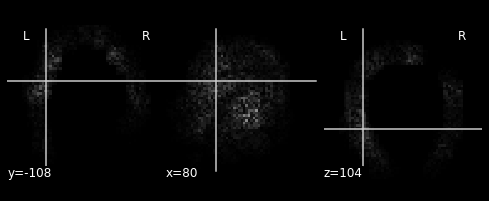

In [41]:
ppp = '/content/drive/My Drive/Capstone/05_Data/02_Sample_MRI/downsampled_resize/T2/sub-NDARINVFJJPAA2A_T2.nii.gz'
org = nib.load(ppp)
plotting.plot_anat(nilearn.image.new_img_like(ppp, grid, affine=None, copy_header=False))
plotting.show()

In [0]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

In [0]:
explainer = OcclusionSensitivity()

In [0]:
?? OcclusionSensitivity

In [44]:
sensitivity_maps = np.array(
            [
                explainer.get_sensitivity_map(mm, X[0], 0, 4)
            ]
        )

SystemError: ignored

In [0]:
image = X[0]
patch_size = 4
class_index=0

In [64]:
image.shape

TensorShape([64, 64, 64, 2])

In [0]:
def apply_grey_patch(image, top_left_x, top_left_y, top_left_z, patch_size):
    """
    Replace a part of the image with a grey patch.
    Args:
        image (numpy.ndarray): Input image
        top_left_x (int): Top Left X position of the applied box
        top_left_y (int): Top Left Y position of the applied box
        patch_size (int): Size of patch to apply
    Returns:
        numpy.ndarray: Patched image
    """
    patched_image = np.array(image, copy=True)
    patched_image[
        top_left_x : top_left_x + patch_size, top_left_y : top_left_y + patch_size, top_left_z : top_left_z + patch_size, 0
    ] = 0

    return patched_image

import math

sensitivity_map = np.zeros((
    math.ceil(image.shape[0] / patch_size),
    math.ceil(image.shape[1] / patch_size),
    math.ceil(image.shape[2] / patch_size),
))

In [66]:
for index_z, top_left_z in enumerate(range(0, image.shape[2], patch_size)):
  print(index_z, top_left_z)
  patches = [
             apply_grey_patch(image, top_left_x, top_left_y, top_left_z, patch_size)
             for index_x, top_left_x in enumerate(range(0, image.shape[0], patch_size))
             for index_y, top_left_y in enumerate(range(0, image.shape[1], patch_size))
            ]
  coordinates = [
               (index_y, index_x)
               for index_x, _ in enumerate(range(0, image.shape[0], patch_size))
               for index_y, _ in enumerate(range(0, image.shape[1], patch_size))
               ]
  predictions = mm.predict(np.array(patches), batch_size=1)
  target_class_predictions = [prediction[class_index] for prediction in predictions]
  for (index_y, index_x), confidence in zip(coordinates, target_class_predictions):
    sensitivity_map[index_y, index_x, index_z] = 1 - confidence

0 0
1 4
2 8
3 12
4 16
5 20
6 24
7 28
8 32
9 36
10 40
11 44
12 48
13 52
14 56
15 60


In [0]:
from skimage.transform import resize

In [0]:
sm = resize(sensitivity_map, (64,64,64))

In [0]:
heatmap = (sm - np.min(sm)) / (sm.max() - sm.min())

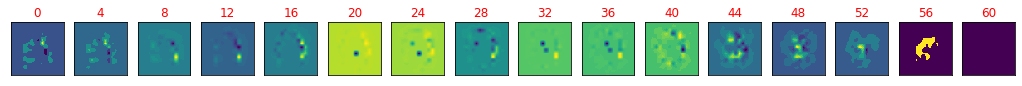

In [80]:
import cv2

step = 4
n_slices = int(64/4)
i = 0
n = 0
data = (heatmap * 255).astype("uint8")
slice = 0
fig, ax = plt.subplots(1, n_slices, figsize=[18, 1.2*1])
for _ in range(n_slices):
  #tmp_data = cv2.applyColorMap(cv2.cvtColor(data[:,:,slice], cv2.COLOR_GRAY2BGR), colormap)
  ax[n].imshow(data[:,:,slice])
  ax[n].set_xticks([])
  ax[n].set_yticks([])
  if i == 0:
    ax[n].set_title(str(slice), color='r')
  else:
    ax[n].set_title('', color='r')
  n += 1
  slice += step


In [0]:
''def apply_grey_patch(image, top_left_x, top_left_y, top_left_z, patch_size):
    """
    Replace a part of the image with a grey patch.
    Args:
        image (numpy.ndarray): Input image
        top_left_x (int): Top Left X position of the applied box
        top_left_y (int): Top Left Y position of the applied box
        patch_size (int): Size of patch to apply
    Returns:
        numpy.ndarray: Patched image
    """
    patched_image = np.array(image, copy=True)
    patched_image[
        top_left_y : top_left_y + patch_size, top_left_x : top_left_x + patch_size, top_left_z : top_left_z + patch_size, :
    ] = 127.5

    return patched_image

import math

sensitivity_map = np.zeros((
    math.ceil(image.shape[0] / patch_size),
    math.ceil(image.shape[1] / patch_size),
    math.ceil(image.shape[2] / patch_size),
))

patches = [
           apply_grey_patch(image, top_left_x, top_left_y, top_left_z, patch_size)
           for index_x, top_left_x in enumerate(range(0, image.shape[0], patch_size))
           for index_y, top_left_y in enumerate(range(0, image.shape[1], patch_size))
           for index_z, top_left_z in enumerate(range(0, image.shape[2], patch_size))
]

coordinates = [
               (index_y, index_x, index_z)
               for index_x, _ in enumerate(range(0, image.shape[0], patch_size))
               for index_y, _ in enumerate(range(0, image.shape[1], patch_size))
]

In [0]:
predictions = mm.predict(np.array(patches), batch_size=1)
target_class_predictions = [
                            prediction[class_index] for prediction in predictions
]

for (index_y, index_x), confidence in zip(coordinates, target_class_predictions):
  sensitivity_map[index_y, index_x] = 1 - confidence

In [179]:
sensitivity_map.shape

(32, 32)

In [159]:
grid = explainer.explain((X[0:1], _), mm, 0, 20, 1.)

SystemError: ignored

In [0]:
from tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()

In [0]:
??GradCAM

In [133]:
model.summary()

Model: "my_dnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
re_lu_2 (ReLU)               multiple                  0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 62, 62, 62, 32)    1760      
_________________________________________________________________
batch_normalization_48 (Batc (None, 62, 62, 62, 32)    128       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 29, 29, 29, 64)    55360     
_________________________________________________________________
batch_normalization_49 (Batc (None, 29, 29, 29, 64)    256       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 12, 12, 12, 128)   221

In [137]:
mm.get_layer('my_dnn_2').get_layer('sequential_40').output

<tf.Tensor 'my_dnn_2/sequential_40/Identity:0' shape=(None, 2) dtype=float32>

In [0]:
grad_model = tf.keras.models.Model(
            [mm.inputs], [mm.get_layer('my_dnn_2').get_layer('lastconv_1').output, mm.get_layer('my_dnn_2').get_layer('sequential_40').output]
        )

In [0]:
import cv2

def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.
    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]
    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")

def heatmap_display(heatmap, original_image, colormap=cv2.COLORMAP_VIRIDIS):
    """
    Apply a heatmap (as an np.ndarray) on top of an original image.
    Args:
        heatmap (numpy.ndarray): Array corresponding to the heatmap
        original_image (numpy.ndarray): Image on which we apply the heatmap
        colormap (int): OpenCV Colormap to use for heatmap visualization
    Returns:
        np.ndarray: Original image with heatmap applied
    """
    heatmap = cv2.resize(heatmap, original_image.shape[0])

    image = image_to_uint_255(original_image)

    heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())

    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap
    )

    output = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 0.7, heatmap, 1, 0)

    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [0]:
colormap=cv2.COLORMAP_VIRIDIS

with tf.GradientTape() as tape:
  X_in = tf.cast(X[0:1], tf.float32)
  conv_outputs, predictions = grad_model(X_in)
  loss = predictions[:, 0]
  tape.watch(loss)
  tape.watch(conv_outputs)
  grads = tape.gradient(loss, conv_outputs)

In [141]:
grads.shape

TensorShape([1, 4, 4, 4, 256])

In [147]:
conv_outputs.shape

TensorShape([1, 4, 4, 4, 256])

In [0]:
guided_grads = (
    tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
)

cams = GradCAM.generate_ponderated_output(conv_outputs, guided_grads)

#heatmaps = np.array([
#                     heatmap_display(cam.numpy(), image, colormap) 
#                     for cam, image in zip(cams, X[0:1])
#                     ]
#)

In [0]:
?? GradCAM

In [0]:
cam = cams[0].numpy()
original_image = X[0].numpy()

In [149]:
cam.shape

(4, 4, 4)

In [150]:
original_image.shape

(64, 64, 64, 2)

In [0]:
image = image_to_uint_255(original_image)

In [0]:
cam = (cam - np.min(cam)) / (cam.max() - cam.min())

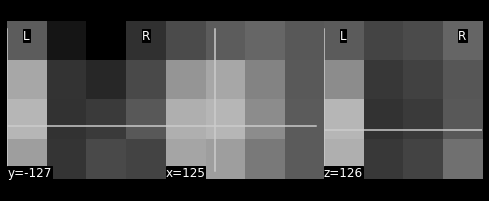

In [152]:
ppp = '/content/drive/My Drive/Capstone/05_Data/02_Sample_MRI/downsampled_resize/T2/sub-NDARINVFJJPAA2A_T2.nii.gz'
org = nib.load(ppp)
plotting.plot_anat(nilearn.image.new_img_like(ppp, cam, affine=None, copy_header=False))
plotting.show()

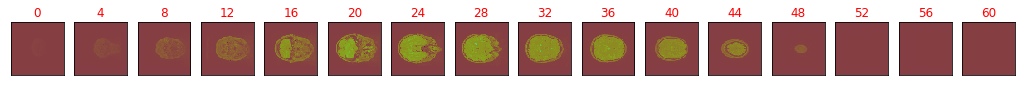

In [108]:
step = 4
n_slices = int(64/4)
i = 0
n = 0
data = (cam * 255).astype("uint8")
slice = 0
fig, ax = plt.subplots(1, n_slices, figsize=[18, 1.2*1])
for _ in range(n_slices):
  tmp_data = cv2.applyColorMap(cv2.cvtColor(data[:,:,slice], cv2.COLOR_GRAY2BGR), colormap)
  ax[n].imshow(tmp_data)
  ax[n].set_xticks([])
  ax[n].set_yticks([])
  if i == 0:
    ax[n].set_title(str(slice), color='r')
  else:
    ax[n].set_title('', color='r')
  n += 1
  slice += step




In [105]:
image[:,:,slice]

array([[[77, 71],
        [77, 71],
        [77, 71],
        ...,
        [77, 71],
        [77, 71],
        [77, 71]],

       [[77, 71],
        [77, 71],
        [77, 71],
        ...,
        [77, 71],
        [77, 71],
        [77, 71]],

       [[77, 71],
        [77, 71],
        [77, 71],
        ...,
        [77, 71],
        [77, 71],
        [77, 71]],

       ...,

       [[77, 71],
        [77, 71],
        [77, 71],
        ...,
        [77, 71],
        [77, 71],
        [77, 71]],

       [[77, 71],
        [77, 71],
        [77, 71],
        ...,
        [77, 71],
        [77, 71],
        [77, 71]],

       [[77, 71],
        [77, 71],
        [77, 71],
        ...,
        [77, 71],
        [77, 71],
        [77, 71]]], dtype=uint8)

In [102]:
cv2.applyColorMap(cv2.cvtColor(data[:,:,slice], cv2.COLOR_GRAY2BGR), colormap)

array([[[133,  63,  66],
        [133,  63,  66],
        [133,  63,  66],
        ...,
        [133,  63,  66],
        [133,  63,  66],
        [133,  63,  66]],

       [[133,  63,  66],
        [133,  63,  66],
        [133,  63,  66],
        ...,
        [133,  63,  66],
        [133,  63,  66],
        [133,  63,  66]],

       [[133,  63,  66],
        [133,  63,  66],
        [133,  63,  66],
        ...,
        [133,  63,  66],
        [133,  63,  66],
        [133,  63,  66]],

       ...,

       [[133,  63,  66],
        [133,  63,  66],
        [133,  63,  66],
        ...,
        [133,  63,  66],
        [133,  63,  66],
        [133,  63,  66]],

       [[133,  63,  66],
        [133,  63,  66],
        [133,  63,  66],
        ...,
        [133,  63,  66],
        [133,  63,  66],
        [133,  63,  66]],

       [[133,  63,  66],
        [133,  63,  66],
        [133,  63,  66],
        ...,
        [133,  63,  66],
        [133,  63,  66],
        [133,  63,  66]]

In [0]:
grads

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


     |████████████████████████████████| 2.4MB 9.5MB/s 


In [0]:
ppp = '/content/drive/My Drive/Capstone/05_Data/02_Sample_MRI/downsampled_resize/T2/sub-NDARINVFJJPAA2A_T2.nii.gz'
org = nib.load(ppp)

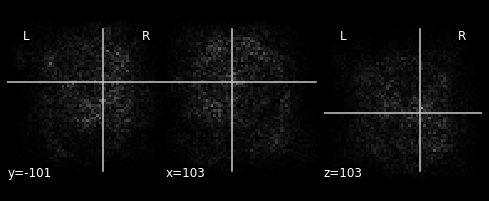

In [0]:
nilearn.image.

In [0]:
import tensorflow as tf

mm = tf.keras.Model(inputs=inputs, output=inputs)

TypeError: ignored

In [0]:
aaa = model.fc['female']

In [0]:
aaa.layers[-1]

In [0]:
list(model.fc['female'].children())

AttributeError: ignored

In [0]:
from tensorflow.keras import Model

class WrapperMyDNN(Model):
  def __init__(self, model):
    super(WrapperMyDNN, self).__init__()
    self.model = model
    #self.output = self.model.fc['female'].layers[-1]
  
  def call(self, x):
    x_tmp = self.model(x)
    return(x_tmp['female'])

In [0]:
?? Model

In [0]:
from tensorflow.keras import Model

class MyDNN2(Model):
  def __init__(self, cat_cols, num_cols, **kwargs):
    super(MyDNN2, self).__init__(**kwargs)
    self.cat_cols = cat_cols
    self.num_cols = num_cols
    self.ac = tf.keras.layers.ReLU()
    self.maxpool = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2), data_format='channels_last')
    self.conv1 = tf.keras.layers.Conv3D(
        filters = 32,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last',
        input_shape = (64,64,64,2)
    )
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv3D(
        filters = 64,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv3 = tf.keras.layers.Conv3D(
        filters = 128,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv3D(
        filters = 256,
        kernel_size = 3,
        padding='valid',
        data_format='channels_last'
    )
    self.bn4 = tf.keras.layers.BatchNormalization()
    self.fc = {}
    for k in list(self.cat_cols.keys()):
      self.fc[k] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(self.cat_cols[k], activation='softmax')
                                        ])
    for i in range(len(self.num_cols)):
      self.fc[self.num_cols[i]] = tf.keras.Sequential([
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dense(1)
                                        ])

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.ac(x)
    x = self.maxpool(x)
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.ac(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    out = {}
    for k in list(self.fc.keys()):
      out[k] = self.fc[k](x)
    return out

In [0]:
model2 = WrapperMyDNN(model)
a = next(iter(test_iter))
t1 = (tf.cast(a['t1'], tf.float32)-t1_mean)/t1_std
t2 = (a['t2']-t2_mean)/t2_std
X = tf.concat([t1, t2], axis=4)

In [0]:
model2.output

AttributeError: ignored

In [0]:
from tf_explain.core.smoothgrad import SmoothGrad
explainer = SmoothGrad()
grid = explainer.explain((X, None), model2, 1, 20, 1.)

AttributeError: ignored

In [0]:
output = []
output.append(['colname', 'mse'])
for col in num_cols:
  mean = test_df[col].mean()
  mse_norm = np.mean(np.square(test_df[col]-mean))
  output.append([col, mse_norm])

for col in list(cat_cols.keys()):
  mean = test_df[col].value_counts().idxmax()
  mse_norm = np.mean(test_df[col]==mean)
  output.append([col, mse_norm])

In [0]:
a = next(iter(test_iter))

In [0]:
t1 = (tf.cast(a['t1'], tf.float32)-t1_mean)/t1_std
t2 = (a['t2']-t2_mean)/t2_std
X = tf.concat([t1, t2], axis=4)

In [0]:
X.shape

TensorShape([8, 64, 64, 64, 2])

In [0]:
model2.model.summary()

Model: "my_dnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
re_lu_2 (ReLU)               multiple                  0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv3d_8 (Conv3D)            multiple                  1760      
_________________________________________________________________
batch_normalization_48 (Batc multiple                  128       
_________________________________________________________________
conv3d_9 (Conv3D)            multiple                  55360     
_________________________________________________________________
batch_normalization_49 (Batc multiple                  256       
_________________________________________________________________
conv3d_10 (Conv3D)           multiple                  221

In [0]:
from tf_explain.core.smoothgrad import SmoothGrad
explainer = SmoothGrad()
grid = explainer.explain((X, None), model2, 1, 20, 1.)

AttributeError: ignored

In [0]:
!ls /content/drive/My\ Drive/Capstone/

 01_ProgressReport	  05_Data		     09_SimpleDLModel
 02_Projects		  06_Ideas		     10_DenseNet
 03_Background_Research   07_AutoFocusLayer	     cat.jpg
 04_Weekly_Meetings	  08_TFRecords_Experiments  'Important notes.gdoc'


In [0]:
IMAGE_PATH = '/content/drive/My Drive/Capstone/cat.jpg'

model_res = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

model_res.summary()
data = ([img], None)

tabby_cat_class_index = 281
explainer = SmoothGrad()
# Compute SmoothGrad on VGG16
grid = explainer.explain(data, model_res, tabby_cat_class_index, 20, 1.)
explainer.save(grid, '.', 'smoothgrad.png')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from google.colab import files

files.download('./smoothgrad.png')

In [0]:
model2(X)

TensorShape([8, 2])

In [0]:
'model.call(X)['female']

<tf.Tensor: id=116151, shape=(8, 2), dtype=float32, numpy=
array([[0.53804183, 0.46195817],
       [0.4839683 , 0.51603174],
       [0.7212447 , 0.2787553 ],
       [0.5602738 , 0.43972617],
       [0.653129  , 0.346871  ],
       [0.5561602 , 0.44383982],
       [0.6063691 , 0.39363095],
       [0.7199904 , 0.2800096 ]], dtype=float32)>

In [0]:
pd.DataFrame(output).to_csv(path_output + 'baseline.csv')

In [0]:
val_df.groupby(['married']).count() / val_df.shape[0]

,subjectkey,age,female,race.ethnicity,high.educ,income,abcd_site,vol,height,weight,BMI,nihtbx_fluidcomp_uncorrected,nihtbx_cryst_uncorrected,nihtbx_pattern_uncorrected,nihtbx_picture_uncorrected,nihtbx_list_uncorrected,nihtbx_flanker_uncorrected,nihtbx_picvocab_uncorrected,nihtbx_cardsort_uncorrected,nihtbx_totalcomp_uncorrected,nihtbx_reading_uncorrected,high.educ_group,income_group,BMI_norm,age_norm,vol_norm,weight_norm,height_norm,nihtbx_fluidcomp_uncorrected_norm,nihtbx_cryst_uncorrected_norm,nihtbx_pattern_uncorrected_norm,nihtbx_picture_uncorrected_norm,nihtbx_list_uncorrected_norm,nihtbx_flanker_uncorrected_norm,nihtbx_picvocab_uncorrected_norm,nihtbx_cardsort_uncorrected_norm,nihtbx_totalcomp_uncorrected_norm,nihtbx_reading_uncorrected_norm
married,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008,0.7008
1,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056,0.0056
2,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808,0.0808
3,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336,0.0336
4,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328,0.1328
5,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464,0.0464


In [0]:
pd.merge(pd.DataFrame(output), df, left_on=0, right_on=0)

,0,1,loss
0,colname,mse,mse
1,age_norm,0.980777,0.980777
2,vol_norm,0.945484,0.945484
3,weight_norm,0.889882,0.889882
4,height_norm,1.0227,1.0227
5,nihtbx_fluidcomp_uncorrected_norm,0.984666,0.984666
6,nihtbx_cryst_uncorrected_norm,1.03023,1.03023
7,nihtbx_pattern_uncorrected_norm,0.969314,0.969314
8,nihtbx_picture_uncorrected_norm,0.95365,0.95365
9,nihtbx_list_uncorrected_norm,1.00613,1.00613


In [0]:
cols = ['nihtbx_fluidcomp_uncorrected', 'nihtbx_cryst_uncorrected', 
              'nihtbx_pattern_uncorrected', 'nihtbx_picture_uncorrected', 
              'nihtbx_list_uncorrected', 'nihtbx_flanker_uncorrected',
              'nihtbx_picvocab_uncorrected', 'nihtbx_cardsort_uncorrected',
              'nihtbx_totalcomp_uncorrected', 'nihtbx_reading_uncorrected']

In [0]:
output = []
output.append(['colname', 'mse'])
for col in cols:
  mean = val_df[col].mean()
  mse_norm = np.mean(np.square(val_df[col]-mean))
  output.append([col, mse_norm])

In [0]:
pd.DataFrame(output)

,0,1
0,colname,mse
1,nihtbx_fluidcomp_uncorrected,0.738561
2,nihtbx_cryst_uncorrected,0.634104
3,nihtbx_pattern_uncorrected,0.872343
4,nihtbx_picture_uncorrected,0.874858
5,nihtbx_list_uncorrected,0.796694
6,nihtbx_flanker_uncorrected,0.832563
7,nihtbx_picvocab_uncorrected,0.673517
8,nihtbx_cardsort_uncorrected,0.837488
9,nihtbx_totalcomp_uncorrected,0.615594


In [0]:
model.get_layer('lastconv')